In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import missingno as msno
import pycountry

os.environ["MODIN_ENGINE"] = "ray"  # Modin will use Ray

# import pandas as pd
import modin.pandas as pd
import ray
ray.init(ignore_reinit_error=True)

from scipy import stats

import warnings
warnings.filterwarnings("ignore")


In [2]:
%run ./module_P2_utils.ipynb

> important notice : import is made with date type parsing specified for date columns, discovered after preliminary analysis

<center><img src="assets/loading.png" alt="drawing" width="500"/></center>

Loading the dataset from csv file


In [3]:
df = pd.read_csv('input/open-food-facts/en.openfoodfacts.org.products.csv', sep='\t', parse_dates=['created_datetime','last_modified_datetime'])

In [4]:
df_bck = df.copy()

In [5]:
df = df_bck.copy()

In [6]:
print(f"dataframe have {df.shape[1]} columns and {df.shape[0]} rows")

dataframe have 186 columns and 1988476 rows


In [7]:
df.head()

,code,url,creator,created_t,created_datetime,last_modified_t,last_modified_datetime,product_name,abbreviated_product_name,generic_name,...,carbon-footprint-from-meat-or-fish_100g,nutrition-score-fr_100g,nutrition-score-uk_100g,glycemic-index_100g,water-hardness_100g,choline_100g,phylloquinone_100g,beta-glucan_100g,inositol_100g,carnitine_100g
0,00000000000000225,http://world-en.openfoodfacts.org/product/0000...,nutrinet-sante,1623855208,2021-06-16 14:53:28+00:00,1623855209,2021-06-16 14:53:29+00:00,jeunes pousses,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,00000000000003429145,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1630483911,2021-09-01 08:11:51+00:00,1630484064,2021-09-01 08:14:24+00:00,L.casei,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,0000000000017,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1529059080,2018-06-15 10:38:00+00:00,1561463718,2019-06-25 11:55:18+00:00,Vitória crackers,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,0000000000031,http://world-en.openfoodfacts.org/product/0000...,isagoofy,1539464774,2018-10-13 21:06:14+00:00,1539464817,2018-10-13 21:06:57+00:00,Cacao,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,000000000003327986,http://world-en.openfoodfacts.org/product/0000...,kiliweb,1574175736,2019-11-19 15:02:16+00:00,1624390765,2021-06-22 19:39:25+00:00,Filetes de pollo empanado,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Content Discovery

What's inside the dataset ?

In [8]:
for col in range(0, df.columns.size):
    print(f'{df.columns[col]:<45} {str(df.dtypes[col]):>}')

code                                          object
url                                           object
creator                                       object
created_t                                     int64
created_datetime                              datetime64[ns, UTC]
last_modified_t                               int64
last_modified_datetime                        datetime64[ns, UTC]
product_name                                  object
abbreviated_product_name                      object
generic_name                                  object
quantity                                      object
packaging                                     object
packaging_tags                                object
packaging_text                                object
brands                                        object
brands_tags                                   object
categories                                    object
categories_tags                               object
categories_en         

<AxesSubplot:title={'center':'repartition of features type in dataset'}, ylabel='None'>

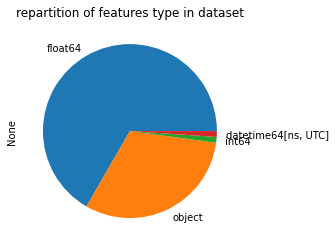

In [9]:
df.dtypes.value_counts().plot.pie(title="repartition of features type in dataset")

Most of the features are qualitative or quantitative. 
Just few of them are date / time based.

<center><img src="assets/data_cleaning.jpeg" alt="drawing" width="500"/></center>

# CLEANING

In this Chapter, we'll remove some of the features (columns) that don't have much interest.


### Investigate `int` and `date` features


In [10]:
df.columns[((df.dtypes != 'float') & (df.dtypes != 'object'))]

Index(['created_t', 'created_datetime', 'last_modified_t',
       'last_modified_datetime'],
      dtype='object')

In [11]:
df.dtypes[['created_t','created_datetime','last_modified_t', 'last_modified_datetime']]

created_t                               int64
created_datetime          datetime64[ns, UTC]
last_modified_t                         int64
last_modified_datetime    datetime64[ns, UTC]
dtype: object

In [12]:
df[['created_t', 'created_datetime', 'last_modified_t', 'last_modified_datetime']].head()

,created_t,created_datetime,last_modified_t,last_modified_datetime
0,1623855208,2021-06-16 14:53:28+00:00,1623855209,2021-06-16 14:53:29+00:00
1,1630483911,2021-09-01 08:11:51+00:00,1630484064,2021-09-01 08:14:24+00:00
2,1529059080,2018-06-15 10:38:00+00:00,1561463718,2019-06-25 11:55:18+00:00
3,1539464774,2018-10-13 21:06:14+00:00,1539464817,2018-10-13 21:06:57+00:00
4,1574175736,2019-11-19 15:02:16+00:00,1624390765,2021-06-22 19:39:25+00:00


In [13]:
pd.to_datetime(df['created_t'], unit='s').head()

0   2021-06-16 14:53:28
1   2021-09-01 08:11:51
2   2018-06-15 10:38:00
3   2018-10-13 21:06:14
4   2019-11-19 15:02:16
Name: created_t, dtype: datetime64[ns]

As we can see, columns are the same between X_datetime and X_t, so we choose to remove one of them

In [14]:
df.drop({
    'created_t', 
    'last_modified_t', 
        }, axis=1, inplace=True)

### Removal of Empty features 

let's compute the ratio: $ \frac{\text{empty values}}{\text{nb rows}} $

<AxesSubplot:ylabel='Frequency'>

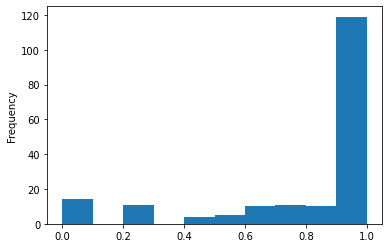

In [15]:
df.sample(round(df.shape[0]*0.02)).isna().mean().sort_values().plot(kind="hist")

About 120 out of 186 columns have more than 80% of empty cells. The dataset despite being large, is almost empty !

<AxesSubplot:>

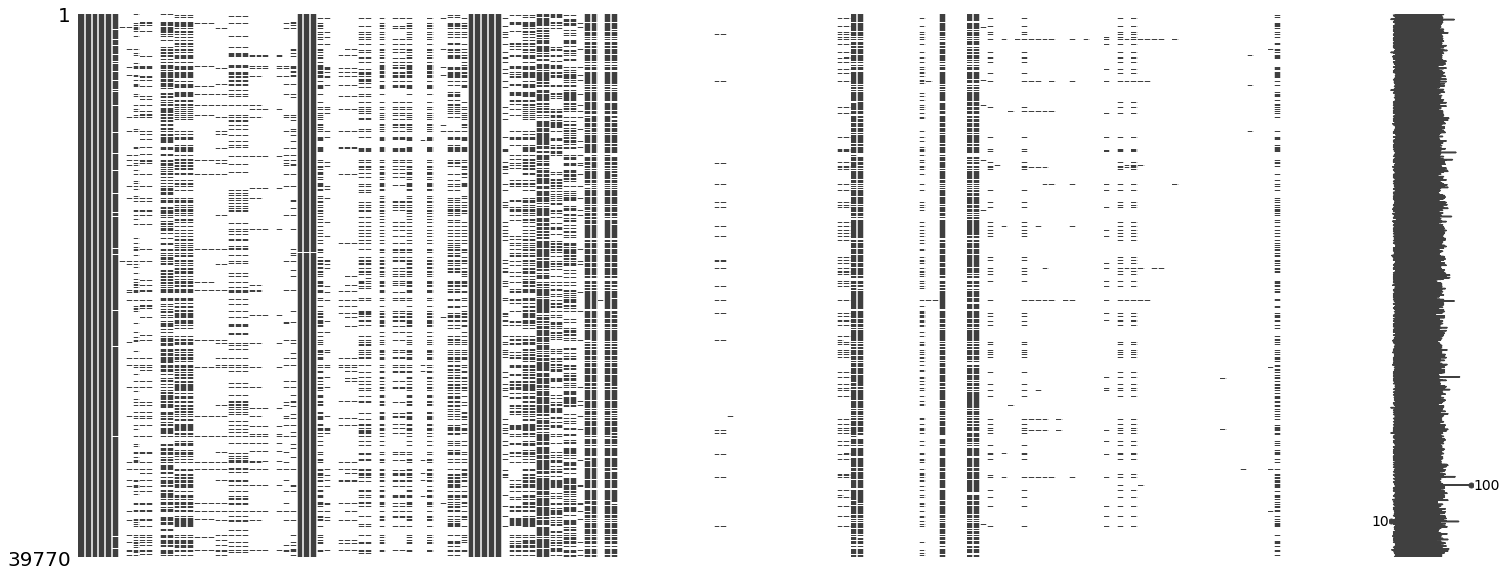

In [16]:
msno.matrix(df.sample(round(df.shape[0]*0.02)))

Taking a sample (20%) of the dataset, to ease compute, we can see there are some plateau of columns missing data, let's consider we want to remove at least those that have more than 70% of missing value.

In [17]:
threshold = 0.7
df = df[df.columns[df.isna().mean() < threshold]]

(apply_list_of_funcs pid=1237100) 


### Removal of Not Interesting features

Some features provides values that won't be of interest for future analysis, we remove them manually.

For instance, features providing `url` are removed

In [18]:
url_columns = df.filter(regex='url').columns.values
print(url_columns)
df = df.drop(url_columns, axis=1)

['url' 'image_url' 'image_small_url' 'image_ingredients_url'
 'image_ingredients_small_url' 'image_nutrition_url'
 'image_nutrition_small_url']


## Results of cleaning

<AxesSubplot:ylabel='None'>

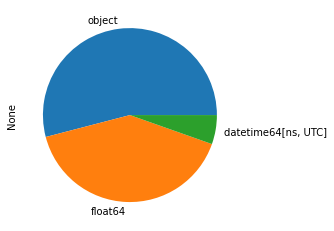

In [19]:
df.dtypes.value_counts().plot.pie()

<AxesSubplot:title={'center':'percentage of missing values per feature'}>

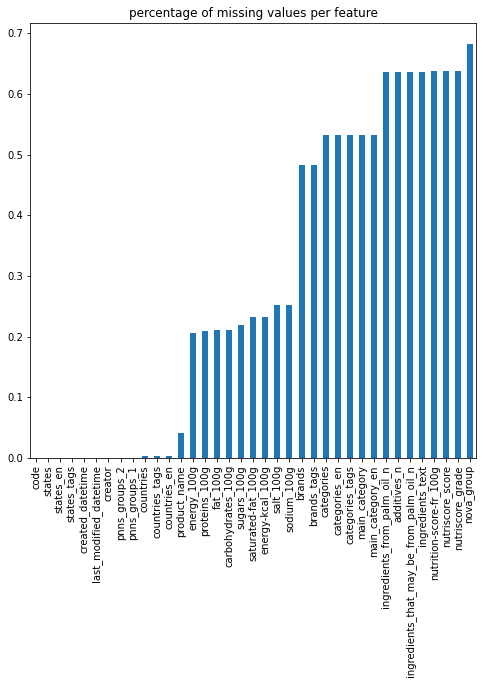

In [23]:
df.isna().mean().sort_values().plot(kind="bar", title='percentage of missing values per feature', figsize=(8,8))

In [26]:
pd.DataFrame({'type': df.dtypes, 'percent_missing_value': df.isna().mean() * 100}).sort_values(by=['percent_missing_value'])

,type,percent_missing_value
code,object,0.000000
states,object,0.000000
states_en,object,0.000000
states_tags,object,0.000000
created_datetime,"datetime64[ns, UTC]",0.000000
last_modified_datetime,"datetime64[ns, UTC]",0.000000
creator,object,0.000201
pnns_groups_2,object,0.009807
pnns_groups_1,object,0.009907
countries,object,0.307572


In [22]:
df.columns.size

37

# Conclusion on Exploratory Data Analysis

## What's provided ?

### Target

Show representations of the dataset through univariate and multivariate analysis

main interesting feature are:
* nutriscore_score
* nutriscore_grade

### Size / Nb lines & columns

Data set contains 186 columns and approx 2Mio lignes

### Types of features / variables

it contains a mix of types : dates, strings, numbers

Interesting ones:

#### Qualitative
* countries_tags
* allergens
* traces
* additives
* pnns_groups_1 [explanation (fr)](https://solidarites-sante.gouv.fr/IMG/pdf/pnns4_2019-2023.pdf)
* pnns_groups_2
* nova_group [explanation (fr)](https://www.thierrysouccar.com/nutrition/info/nova-une-classification-des-aliments-basee-sur-la-science-3936)
* brand_owner ?
* main_category

#### Quantitative
* serving_size
* serving_quantity
* no_nutriments
* additives_n
* ingredients_from_palm_oil_n
* ingredients_that_may_be_from_palm_oil_n
* nutriscore_score
* nutriscore_grade
* ecoscore_score_fr
* ecoscore_grade_fr

Detailed variables :

* abcd_100g

### Missing values identification

What are the features which have lots of NaN / empty values ?


## What's in it ?

* Target visualisation (hist, boxplot)

* Features comprehension

* Features - target relations

* Outliers recognition

## After Cleaning

We now have a dataset with 37 remaining columns, which have at least 30% of data filled in each. 

Only 3 kind of types exists.

We can start analysing the values, in a consistent way

In [ ]:
df.to_pickle("./df_01_cleaned.pkl")